In [12]:
import numpy as np
import pandas as pd
import math, os
import more_itertools as mit
import matplotlib.backends.backend_pdf as pdf
import matplotlib

# Export text as editable text instead of shapes:
matplotlib.rcParams['pdf.fonttype'] = 42

# Preserve the vertical order of embedded images:
matplotlib.rcParams['image.composite_image'] = False

In [13]:
fps = 2
sh = 1 # direction in which to shift vector for delta calculations
threshold = 2 # consecutive seconds spent moving
still_threshold = 10 # seconds for minimum still num count
angle_thresh = 20 # Allowed error from previous angle
sharp_angle = 45
spiral_thresh = 4
spiral_speed_thresh = np.inf

In [14]:
def safe_divide(x, y):
    x = safe_get(x)
    y = safe_get(y)
    try: 
        ans = x / y
    except ZeroDivisionError: 
        return 0
    return ans
    
def safe_get(x, ans=0):
    if math.isnan(x):
        return ans
    return x

In [15]:
# Analyze acclimation data
df = pd.read_csv("./data/experiment_IDs/cleaned_static_data.csv")

animals = df["animal_ID"].unique()
# Check that animal IDs in dataframe are unique
assert len(df) == len(animals)

fps = 2
master_df = pd.DataFrame()

for index, row in df.iterrows():
    animal = row['animal_ID']
    aID = animal[:9]
    pos = animal[10:]
    
    filename = "./data/trajectories/video_calculations/"+aID+'-E-'+pos+'.csv'
    
    if os.path.isfile(filename):
        temp = pd.read_csv(filename)
        
        # Get the change in the change in angle 
        temp['angle_delta_2'] = temp['angle_delta'].shift(sh)
        temp['angle_delta_delta'] = temp['angle_delta']-temp['angle_delta_2']
        temp['angle_delta_delta'] = np.abs(temp['angle_delta_delta'])
        temp_move = temp[temp["moving"] == True]
        
        # % TIME SPENT MOVING, percent ------------------------------
        if len(temp_move) > 0:
            time_move = 100*len(temp_move)/len(temp)
        else:
            time_move = 0
            
        # TOTAL DISTANCE TRAVELED, in meters
        total_dist = temp['speed_mm_s'].sum()/fps/1000
        
        # MAXIMUM SPEED
        max_speed = temp['speed_BL'].max()
        
        # AVERAGE SPEED FOR FIRST MINUTE
        mean_speed_first = temp[temp['frames'] <= 60*fps]['speed_BL'].mean()
        
        # DIFFERENCE BETWEEN FIRST and LAST MINUTES
        diff_speed_f_l = temp[temp['frames'] >= 14*60*fps]['speed_BL'].mean() - mean_speed_first
        
        # AVERAGE SPEED WHEN MOVING
        if len(temp_move) == 0:
            avg_speed = 0
        else:
            avg_speed = temp_move['speed_BL'].mean()
            # CHECKS for any movement of more than a threshold mm/s
            if max(temp_move['speed_mm_s']) > 50:  
                print(max(temp_move['speed_mm_s']), str(aID+'-E-'+pos))
        
        # NUMBER OF SLOW MOVING SPIRALS
        temp_move_side1 = temp_move[temp_move['angle_delta'] < 0]
        temp_move_side2 = temp_move[temp_move['angle_delta'] > 0]
        timestamps1 = [list(x) for x in mit.consecutive_groups(temp_move_side1.index)]
        timestamps2 = [list(x) for x in mit.consecutive_groups(temp_move_side2.index)]
        timestamps1 = [x for x in timestamps1 if len(x) > spiral_thresh*fps]
        timestamps2 = [x for x in timestamps2 if len(x) > spiral_thresh*fps]
        small_spirals, total_timestamps = 0, []
        for thresh_time in timestamps1+timestamps2: 
            thresh_time = [thresh_time[0]-1]+thresh_time
            df_thresh = temp[temp.index.isin(thresh_time)]
            if np.mean(df_thresh['speed_mm_s']) < spiral_speed_thresh:
                small_spirals += 1
                total_timestamps += df_thresh['frames'].tolist()
        
        # NUMBER OF SHARP TURNS
        temp_sharp = temp[temp['speed_mm_s'] > 4]
        temp_sharp = temp_sharp[(temp_sharp['angle_delta'] < -sharp_angle) | \
                                (temp_sharp['angle_delta'] > sharp_angle)]
        temp_sharp = [x-1 for x in temp_sharp['frames'].tolist()]
        temp_sharp = temp[temp['frames'].isin(temp_sharp)]
        sharp_turns = 100*safe_divide(len(temp_sharp),len(temp))
        
        # NUMBER OF CONTINUOUS PATHS
        # PROPORTION OF DISTANCE MOVING CONTINUOUSLY, EXCLUDING SPIRALS
        temp_move_cons = temp_move[temp_move['angle_delta_delta'] <= angle_thresh]
        # Remove spirals using total_timestamps 
        temp_move_cons = temp_move_cons[~temp_move_cons['frames'].isin(total_timestamps)]
        timestamps = [list(x) for x in mit.consecutive_groups(temp_move_cons.index)]
        continuous_nums = 0
        for thresh_time in timestamps: 
            thresh_time = [thresh_time[0]-1]+thresh_time
            df_thresh = temp[temp.index.isin(thresh_time)]
            continuous_nums += 1

        # MAXIMUM REST LENGTH IN SECONDS
        temp_still = temp[temp["moving"] == False]
        timestamps = [list(x) for x in mit.consecutive_groups(temp_still.index)]
        thresh_times = [x for x in timestamps if len(x) > still_threshold*fps]
        still_len = []
        for thresh_time in thresh_times:
            thresh_time = [thresh_time[0]-1]+thresh_time
            df_thresh = temp[temp.index.isin(thresh_time)]
            still_len.append(len(df_thresh))
        if len(still_len) > 0:
            still_len_max = np.max(still_len)/fps # in seconds
        else:
            still_len_max = 0

        temp = pd.DataFrame({
            # STATIC VARIABLES ----------------------------
            "animal_ID": [row["animal_ID"]], 
            "treatment_odor": row["treatment_odor"],
            "sex": row["sex"], 
            "species": row['species'],
            'dead':row['dead'],
            "length_mm": row['larvae_length_mm'],

            # VARIABLES CALCULATED THROUGHOUT VIDEO -------
            "time_move_p": time_move,
            "total_dist_m": total_dist,
            "avg_speed_BL": avg_speed,
            "max_speed_BL": max_speed,
            "mean_speed_first_BL": mean_speed_first,
            "diff_speed_first_last_BL": diff_speed_f_l,
            "sharp_turns_p": sharp_turns,
            "spirals": small_spirals,
            "continuous": continuous_nums, 
            "max_still_sec": still_len_max,
            })
        master_df = pd.concat([master_df, temp])

master_df.to_csv('./data/trajectories/Jeff_experiment_test.csv', index=False)
# display(master_df.head())
print('--- Finished with saving df! ---')

50.525553798383044 190725-03-E-top
51.636421258234 190725-03-E-bottom
61.21351172977182 190727-03-E-bottom
83.47516777098897 191108-01-E-bottom
56.81893738962938 191109-09-E-bottom
52.78976322986554 191110-01-E-bottom
--- Finished with saving df! ---


In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [17]:
df_o = pd.read_csv('./data/trajectories/cleaned_animal_analyses_acclimation.csv')
df_o['color'] = df_o['species']
df_o['color'] = df_o['color'].str.replace('Aedes aegypti', '#224099')
df_o['color'] = df_o['color'].str.replace('Aedes albopictus', '#96509f')
df_o['color'] = df_o['color'].str.replace('Anopheles arabiensis', '#d84b27')
df_o['color'] = df_o['color'].str.replace('Anopheles gambiae', '#e69f00')
df_o['color'] = df_o['color'].str.replace('Culex quinquefasciatus', '#009e73')
df_o['color'] = df_o['color'].str.replace('Culex tarsalis', '#47c4d7')

df = df_o[['time_move_p', 'total_dist_m',
                  'avg_speed_BL', 'max_speed_BL',
                  'mean_speed_first_BL', 'diff_speed_first_last_BL',
                  'sharp_turns_p', 'spirals', 'continuous', 'max_still_sec']]
dataset_1_X=(df-df.mean())/df.std()
display(dataset_1_X.head())
dt = dataset_1_X.values
display(dt)

,time_move_p,total_dist_m,avg_speed_BL,max_speed_BL,mean_speed_first_BL,diff_speed_first_last_BL,sharp_turns_p,spirals,continuous,max_still_sec
0,2.342483,3.742605,0.411785,-0.088114,0.912613,0.910029,2.498542,0.077161,3.187958,-0.918402
1,1.817717,3.847988,0.504370,-0.558766,-0.662931,2.332823,1.890854,0.077161,2.382473,-0.833640
2,-1.375619,-1.327891,-1.510264,-1.606734,-0.988798,0.356975,-1.215311,-0.606462,-1.434824,1.990005
3,-0.021121,-0.636631,-1.111715,-0.977158,-0.010096,-0.071097,-0.451545,-0.435556,-0.086512,-0.065481
4,-0.307556,-0.402780,-0.526049,-0.845360,-0.370604,-0.082410,-0.160586,-0.606462,-0.226597,-0.449560


array([[ 2.3424825 ,  3.74260521,  0.41178539, ...,  0.07716147,
         3.187958  , -0.91840187],
       [ 1.81771717,  3.84798794,  0.50437003, ...,  0.07716147,
         2.38247329, -0.83363955],
       [-1.37561876, -1.32789057, -1.51026434, ..., -0.60646207,
        -1.43482382,  1.99000535],
       ...,
       [ 0.69380671,  0.18610981, -0.76736308, ...,  0.58987912,
         0.63141957, -0.72503782],
       [ 1.03345605, -0.13682512, -1.04918129, ...,  2.12803207,
        -0.4367232 , -0.2535474 ],
       [ 0.11490259, -0.30855121, -0.86659801, ...,  1.27350265,
        -0.40170213, -0.4760485 ]])

In [18]:
def plot_pca(ax, pcadata, colordf, title):
    df2 = pd.DataFrame.from_dict({"pc1":[x[0] for x in pcadata], 
                                  "pc2":[x[1] for x in pcadata],
                                  "color":colordf['color'].tolist()})
    ax.scatter(df2['pc1'], df2['pc2'], c=df2['color'], clip_on=False, s=6)
    ax.axhline(y=0, xmin=0, xmax=1, zorder=20, color='k')
    ax.axvline(x=0, ymin=0, ymax=1, zorder=20, color='k')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-8, 8)
    ax.set_title(title)
    return ax

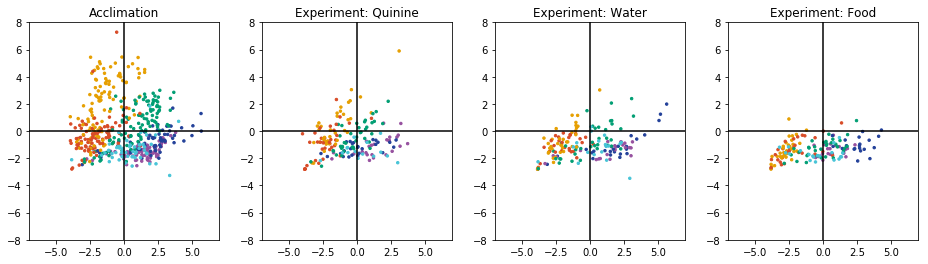

In [19]:
pca = PCA(n_components=2)
pca_X1 = pca.fit_transform(dt)

df_3 = pd.read_csv('./data/trajectories/Jeff_experiment_test.csv')
df_3['color'] = df_3['species']
df_3['color'] = df_3['color'].str.replace('Aedes aegypti', '#224099')
df_3['color'] = df_3['color'].str.replace('Aedes albopictus', '#96509f')
df_3['color'] = df_3['color'].str.replace('Anopheles arabiensis', '#d84b27')
df_3['color'] = df_3['color'].str.replace('Anopheles gambiae', '#e69f00')
df_3['color'] = df_3['color'].str.replace('Culex quinquefasciatus', '#009e73')
df_3['color'] = df_3['color'].str.replace('Culex tarsalis', '#47c4d7')

quinine = df_3[df_3['treatment_odor']=='100ul_quinine']
qcol = quinine.copy()
quinine = quinine[['time_move_p', 'total_dist_m','avg_speed_BL', 'max_speed_BL',
                  'mean_speed_first_BL', 'diff_speed_first_last_BL',
                  'sharp_turns_p', 'spirals', 'continuous', 'max_still_sec']]
quinine = (quinine-df.mean())/df.std()
quinine = quinine.values

water = df_3[df_3['treatment_odor']=='100ul_milliQ_water']
wcol = water.copy()
water = water[['time_move_p', 'total_dist_m','avg_speed_BL', 'max_speed_BL',
                  'mean_speed_first_BL', 'diff_speed_first_last_BL',
                  'sharp_turns_p', 'spirals', 'continuous', 'max_still_sec']]
water = (water-df.mean())/df.std()
water = water.values

food = df_3[df_3['treatment_odor']=='05_percent_food']
fcol = food.copy()
food = food[['time_move_p', 'total_dist_m','avg_speed_BL', 'max_speed_BL',
                  'mean_speed_first_BL', 'diff_speed_first_last_BL',
                  'sharp_turns_p', 'spirals', 'continuous', 'max_still_sec']]
food = (food-df.mean())/df.std()
food = food.values

pca_X2 = pca.transform(quinine)
pca_X3 = pca.transform(water)
pca_X4 = pca.transform(food)

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(141, aspect="equal")
ax2 = fig.add_subplot(142, aspect="equal")
ax3 = fig.add_subplot(143, aspect="equal")
ax4 = fig.add_subplot(144, aspect="equal")

ax1 = plot_pca(ax1, pca_X1, df_o, 'Acclimation')
ax2 = plot_pca(ax2, pca_X2, qcol, 'Experiment: Quinine')
ax3 = plot_pca(ax3, pca_X3, wcol, 'Experiment: Water')
ax4 = plot_pca(ax4, pca_X4, fcol, 'Experiment: Food')

pp = pdf.PdfPages('./PCA_supplemental_2.pdf', keep_empty=False)
pp.savefig(fig)
pp.close()
plt.show()